
Training agents...


Training SARSA: 100%|██████████| 1500/1500 [01:05<00:00, 22.73it/s]


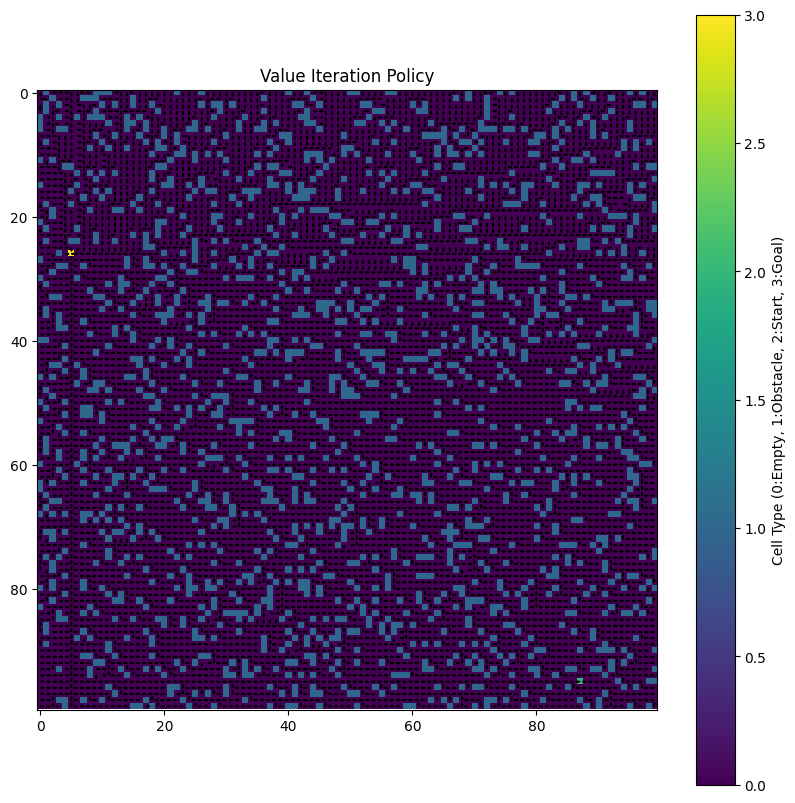

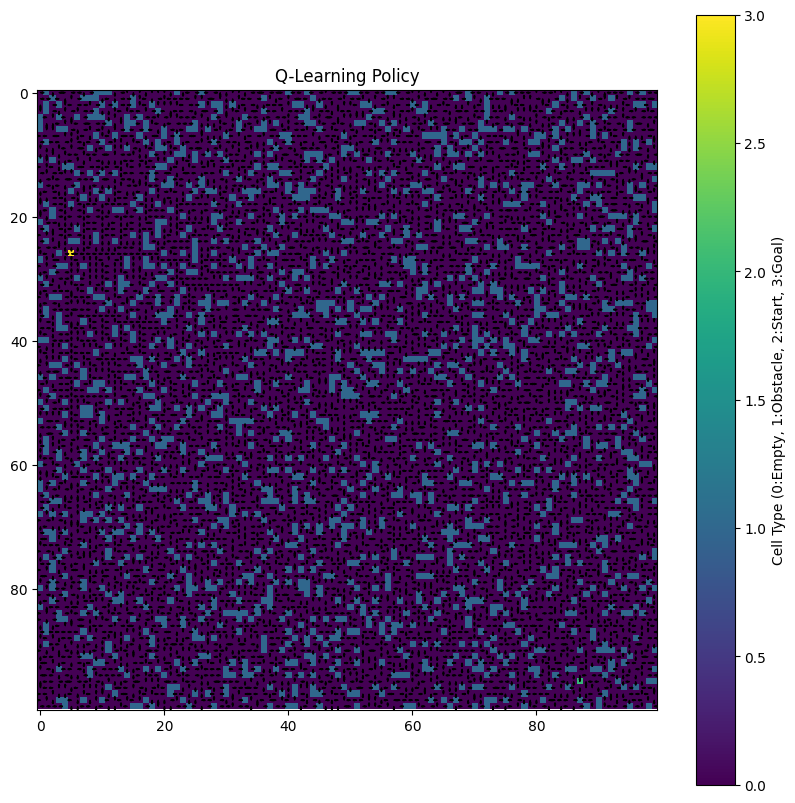

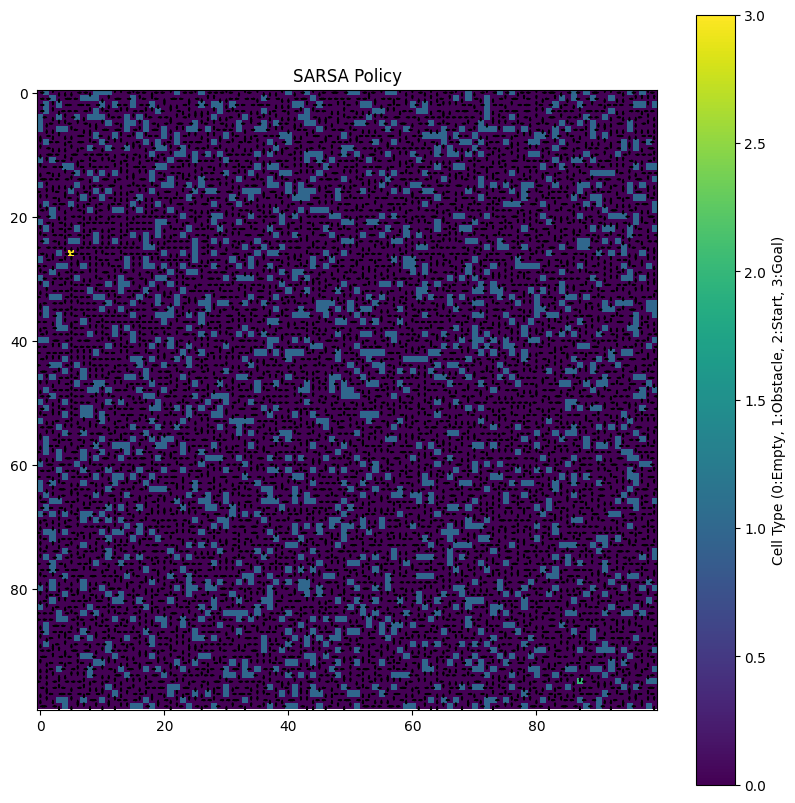

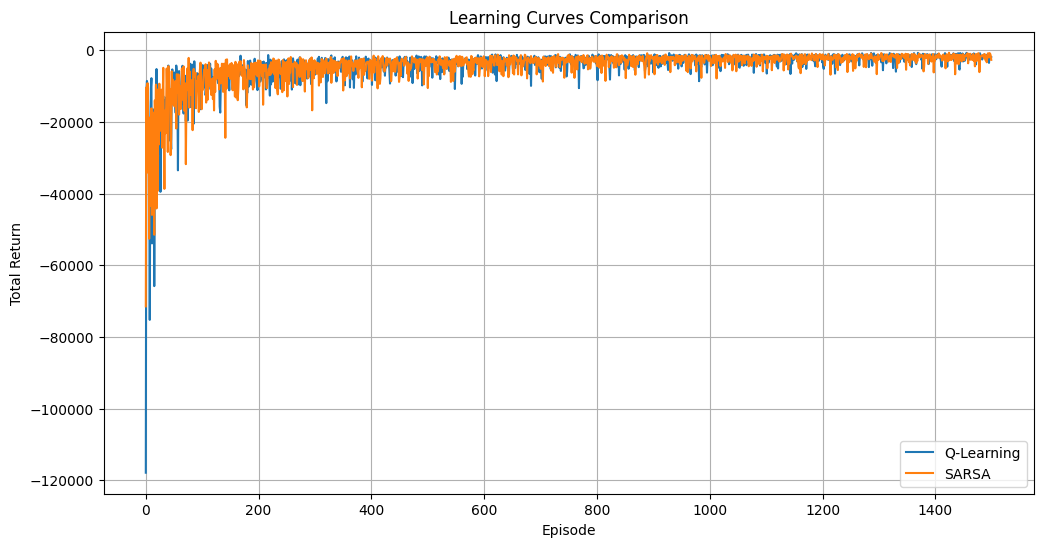


Training Time Comparison:
Value Iteration: 94.99 seconds
Q-Learning: 105.42 seconds
SARSA: 66.01 seconds

Final Performance (last 100 episodes average):
Q-Learning: -1902.35
SARSA: -1930.61


In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import random
import time

class GridWorldEnv:
    def __init__(self, size=100, obstacle_density=0.2):  # Reduced obstacle density
        self.size = size
        self.grid = np.zeros((size, size))
        self.actions = [(0, 1), (1, 0), (0, -1), (-1, 0)]  # right, down, left, up
        self.num_actions = len(self.actions)

        # Generate random start and goal positions
        self.start = (random.randint(0, size-1), random.randint(0, size-1))
        self.goal = (random.randint(0, size-1), random.randint(0, size-1))

        # Ensure start and goal are different
        while self.goal == self.start:
            self.goal = (random.randint(0, size-1), random.randint(0, size-1))

        # Generate obstacles
        self._generate_obstacles(obstacle_density)

        # Ensure path exists between start and goal
        self._ensure_path_exists()

        # Set start and goal positions
        self.grid[self.start] = 2  # Start position
        self.grid[self.goal] = 3   # Goal position

    def _generate_obstacles(self, density):
        num_obstacles = int(self.size * self.size * density)
        for _ in range(num_obstacles):
            x, y = random.randint(0, self.size-1), random.randint(0, self.size-1)
            while (x, y) in [self.start, self.goal]:
                x, y = random.randint(0, self.size-1), random.randint(0, self.size-1)
            self.grid[x, y] = 1

    def _ensure_path_exists(self):
        # Simple implementation: create a clear path between start and goal
        x, y = self.start
        goal_x, goal_y = self.goal

        # Clear horizontal path
        for j in range(min(y, goal_y), max(y, goal_y) + 1):
            self.grid[x, j] = 0

        # Clear vertical path
        for i in range(min(x, goal_x), max(x, goal_x) + 1):
            self.grid[i, goal_y] = 0

    def reset(self):
        return self.start

    def step(self, state, action):
        x, y = state
        dx, dy = self.actions[action]
        new_x, new_y = x + dx, y + dy

        # Check bounds and obstacles
        if (new_x < 0 or new_x >= self.size or
            new_y < 0 or new_y >= self.size or
            self.grid[new_x, new_y] == 1):
            return state, -1, False

        new_state = (new_x, new_y)
        reward = 100 if new_state == self.goal else -1
        done = new_state == self.goal

        return new_state, reward, done

    def get_valid_actions(self, state):
        valid = []
        for i, (dx, dy) in enumerate(self.actions):
            new_x, new_y = state[0] + dx, state[1] + dy
            if (0 <= new_x < self.size and
                0 <= new_y < self.size and
                self.grid[new_x, new_y] != 1):
                valid.append(i)
        # If no valid actions, return all actions (will stay in place)
        return valid if valid else list(range(self.num_actions))

class ValueIteration:
    def __init__(self, env, gamma=0.99):
        self.env = env
        self.gamma = gamma
        self.V = {}
        self.policy = {}

        # Initialize value function
        for i in range(env.size):
            for j in range(env.size):
                if env.grid[i, j] != 1:  # If not obstacle
                    self.V[(i, j)] = 0
                    self.policy[(i, j)] = 0

    def train(self, max_iterations=1500, theta=1e-6):
        for _ in range(max_iterations):
            delta = 0
            for state in self.V.keys():
                v = self.V[state]
                max_v = float('-inf')
                best_action = 0

                valid_actions = self.env.get_valid_actions(state)
                if not valid_actions:  # If no valid actions
                    continue

                for action in valid_actions:
                    next_state, reward, done = self.env.step(state, action)
                    if done:
                        v_next = reward
                    else:
                        v_next = reward + self.gamma * self.V.get(next_state, 0)
                    if v_next > max_v:
                        max_v = v_next
                        best_action = action

                self.V[state] = max_v
                self.policy[state] = best_action
                delta = max(delta, abs(v - self.V[state]))

            if delta < theta:
                break

    def get_action(self, state):
        return self.policy.get(state, 0)

class QLearning:
    def __init__(self, env, learning_rate=0.1, gamma=0.99, epsilon=0.1):
        self.env = env
        self.lr = learning_rate
        self.gamma = gamma
        self.epsilon = epsilon
        self.Q = {}

        # Initialize Q-values
        for i in range(env.size):
            for j in range(env.size):
                if env.grid[i, j] != 1:  # If not obstacle
                    self.Q[(i, j)] = np.zeros(env.num_actions)

    def get_action(self, state, training=True):
        valid_actions = self.env.get_valid_actions(state)
        if training and random.random() < self.epsilon and valid_actions:
            return random.choice(valid_actions)
        return np.argmax(self.Q[state])

    def train(self, episodes=1000):
        returns = []
        for _ in tqdm(range(episodes), desc="Training Q-Learning"):
            state = self.env.reset()
            total_reward = 0
            done = False

            while not done:
                action = self.get_action(state)
                next_state, reward, done = self.env.step(state, action)
                total_reward += reward

                if next_state not in self.Q:
                    self.Q[next_state] = np.zeros(self.env.num_actions)

                # Q-learning update
                if done:
                    self.Q[state][action] = (1 - self.lr) * self.Q[state][action] + self.lr * reward
                else:
                    self.Q[state][action] = (1 - self.lr) * self.Q[state][action] + \
                        self.lr * (reward + self.gamma * np.max(self.Q[next_state]))

                state = next_state

            returns.append(total_reward)
        return returns

class SARSA:
    def __init__(self, env, learning_rate=0.1, gamma=0.99, epsilon=0.1):
        self.env = env
        self.lr = learning_rate
        self.gamma = gamma
        self.epsilon = epsilon
        self.Q = {}

        # Initialize Q-values
        for i in range(env.size):
            for j in range(env.size):
                if env.grid[i, j] != 1:  # If not obstacle
                    self.Q[(i, j)] = np.zeros(env.num_actions)

    def get_action(self, state, training=True):
        valid_actions = self.env.get_valid_actions(state)
        if training and random.random() < self.epsilon and valid_actions:
            return random.choice(valid_actions)
        return np.argmax(self.Q[state])

    def train(self, episodes=1000):
        returns = []
        for _ in tqdm(range(episodes), desc="Training SARSA"):
            state = self.env.reset()
            total_reward = 0
            done = False

            action = self.get_action(state)

            while not done:
                next_state, reward, done = self.env.step(state, action)
                total_reward += reward

                if next_state not in self.Q:
                    self.Q[next_state] = np.zeros(self.env.num_actions)

                next_action = self.get_action(next_state) if not done else 0

                # SARSA update
                if done:
                    self.Q[state][action] = (1 - self.lr) * self.Q[state][action] + self.lr * reward
                else:
                    self.Q[state][action] = (1 - self.lr) * self.Q[state][action] + \
                        self.lr * (reward + self.gamma * self.Q[next_state][next_action])

                state = next_state
                action = next_action

            returns.append(total_reward)
        return returns

def visualize_policy(env, agent, title):
    plt.figure(figsize=(10, 10))

    # Create a visualization grid
    vis_grid = env.grid.copy()

    # Plot optimal actions
    for i in range(env.size):
        for j in range(env.size):
            if env.grid[i, j] != 1:  # If not obstacle
                action = agent.get_action((i, j))
                if action == 0:  # right
                    plt.arrow(j, i, 0.3, 0, head_width=0.2)
                elif action == 1:  # down
                    plt.arrow(j, i, 0, 0.3, head_width=0.2)
                elif action == 2:  # left
                    plt.arrow(j, i, -0.3, 0, head_width=0.2)
                elif action == 3:  # up
                    plt.arrow(j, i, 0, -0.3, head_width=0.2)

    plt.imshow(vis_grid)
    plt.title(title)
    plt.colorbar(label='Cell Type (0:Empty, 1:Obstacle, 2:Start, 3:Goal)')
    plt.show()

def compare_performance(env, episodes=1500):
    # Train all agents
    print("\nTraining agents...")

    # Value Iteration
    start_time = time.time()
    vi_agent = ValueIteration(env)
    vi_agent.train()
    vi_time = time.time() - start_time

    # Q-Learning
    start_time = time.time()
    q_agent = QLearning(env)
    q_returns = q_agent.train(episodes)
    q_time = time.time() - start_time

    # SARSA
    start_time = time.time()
    sarsa_agent = SARSA(env)
    sarsa_returns = sarsa_agent.train(episodes)
    sarsa_time = time.time() - start_time

    # Visualize policies
    visualize_policy(env, vi_agent, "Value Iteration Policy")
    visualize_policy(env, q_agent, "Q-Learning Policy")
    visualize_policy(env, sarsa_agent, "SARSA Policy")

    # Plot learning curves
    plt.figure(figsize=(12, 6))
    plt.plot(q_returns, label='Q-Learning')
    plt.plot(sarsa_returns, label='SARSA')
    plt.title('Learning Curves Comparison')
    plt.xlabel('Episode')
    plt.ylabel('Total Return')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Print timing comparison
    print("\nTraining Time Comparison:")
    print(f"Value Iteration: {vi_time:.2f} seconds")
    print(f"Q-Learning: {q_time:.2f} seconds")
    print(f"SARSA: {sarsa_time:.2f} seconds")

    # Calculate and print average returns
    print("\nFinal Performance (last 100 episodes average):")
    print(f"Q-Learning: {np.mean(q_returns[-100:]):.2f}")
    print(f"SARSA: {np.mean(sarsa_returns[-100:]):.2f}")

    return vi_agent, q_agent, sarsa_agent

# Create environment and run comparison
env = GridWorldEnv(size=100)
vi_agent, q_agent, sarsa_agent = compare_performance(env)